In [ ]:
!pip install plotly # '!' is for OS command for online notebooks

In [2]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import plotly_express as px
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
import statsmodels.api as sm
from sklearn.metrics import *
from pandas_profiling import ProfileReport
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import itertools

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [27]:
#Creating basic plotting for the whole notebook
%matplotlib inline
warnings.filterwarnings('ignore')

Utility Functions

In [24]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

**ACER STOCK ANALYSIS**

In [5]:
#Loading Acer Stock to Dataframe
df = pd.read_csv("/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/acer.us.txt")
df.head() #First 5 rows of df

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,17000.00,17000.00,17000.00,17000.00,0,0
1,2005-02-28,16666.67,17500.00,16666.67,17500.00,1,0
2,2005-03-01,16833.33,16833.33,16500.00,16500.00,1,0
3,2005-03-02,15000.00,16333.33,15000.00,15000.00,0,0
4,2005-03-03,15833.33,16833.33,15833.33,16833.33,1,0


Data Information

In [ ]:
print("(Rows, Columns) of given data: ", df.shape)
print("Column Header of given data: ",df.columns)

In [ ]:
#Only 4 columns are relevant for stock forecasting analysis:
imp_col = ['Open', 'High', 'Low', 'Close']

Statistical Analysis

In [ ]:
#Getting statistical values for 'imp_col'
df[imp_col].describe()

In [ ]:
#Correlation btw diff columns
#https://www.geeksforgeeks.org/pandas-profiling-in-python/
ProfileReport(df[imp_col])

**Exploratory Data Analysis (EDA)** *relevant for plotting*

In [ ]:
#px is plotly_express
px.line(df, x="Date", y="Close", title='Closing Price v/s Date')

In [ ]:
px.line(df, x="Date", y="Open", title='Opening Price vs Date')

In [ ]:
px.line(df, x="Date", y="High", title='High Price vs Date') 
#High price is the highest price of the stock for a particular date

In [ ]:
px.line(df, x="Date", y="Low", title='Low Price vs Date') 
#High price is the lowest price of the stock for a particular date

In [ ]:
# Cumulative Return
dr = df[imp_col].cumsum()
dr.plot()
plt.title('Acer Stock Cumulative Returns')
plt.show()

In [ ]:
for i in imp_col:
    lag_plot(df[i], lag=7)
    plt.title('Acer Stock Autocorrelation plot for '+i+' Price')
    plt.show()

**SARIMA (Seasonal Auto-Regressive Integrated Moving Average) Model for Time Series Prediction**

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

In [ ]:
#SARIMA works with Date hence original index is set per date
df = df.reset_index()
df = df.set_index('Date')
df.head()

Opening Price - SARIMA

In [ ]:
#To avoid NaN tracebacks, 2 weeks data is sampled
t = df['Open'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))


# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

Closing Price - SARIMA

In [ ]:
t = df['Close'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

High Price - SARIMA

In [ ]:
t = df['High'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

Low Price - SARIMA

In [ ]:
t = df['Low'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

ARIMA Model for Stock Market Forecasting

In [ ]:
t = df['Open'].resample('2W').mean()

mod = ARIMA(t,order=(2, 1, 1))
results = mod.fit()
print(results.summary())

# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2,figsize=(16, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


# Actual vs Fitted
plt.figure(figsize=(16, 8))
results.predict().plot(label='Forcasted stock price')
t.plot(label='Actual Stock price')
plt.legend()
plt.show()

Forecast Vs Actual

In [ ]:
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

**LSTM (Long Short Term Memory) Deep Learning**

It's a recurrent neural network

In [7]:
scaler = MinMaxScaler(feature_range=(0,1)) #Normalizing the values btw 0 and 1
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [8]:
scaled_data.shape #Gives no. of rows * no. of columns

(3125, 1)

In [9]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape) #Adding 3rd dimension as in LSTM NN we need data shape to be in 3-D

(3065, 60)
(3065, 60, 1)


In [11]:
def LSTM_model():
    #It is a sequential model so initialising Seq. class object
    model = Sequential()
    #LSTM layer having 50 filters
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    #To protect the model from overfitting, i.e. 20% of the layers would be deleted
    model.add(Dropout(0.2))
    #Adding another 50-filter LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [13]:
model = LSTM_model() 
model.summary()
model.compile(optimizer='adam', #It is the fastest optimizer
              loss='mean_squared_error') 

2022-08-07 10:14:27.314557: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [14]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=5, #Number of time to train model ... later train till 100 tries
          batch_size = 32, 
          callbacks = [checkpointer])

2022-08-07 10:14:32.291755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
96/96 [==============================] - 20s 142ms/step - loss: 4.1817e-04
Epoch 2/5
96/96 [==============================] - 13s 141ms/step - loss: 1.6699e-04
Epoch 3/5
96/96 [==============================] - 14s 146ms/step - loss: 1.4748e-04
Epoch 4/5
96/96 [==============================] - 13s 139ms/step - loss: 2.0097e-04
Epoch 5/5
96/96 [==============================] - 13s 138ms/step - loss: 1.7079e-04


In [15]:
y_pred = model.predict(x_train)
y_pred.shape

(3065, 1)

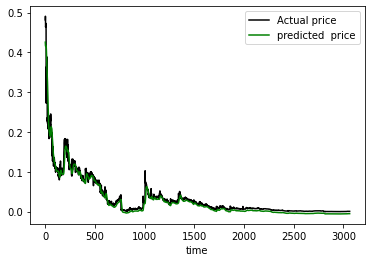

In [28]:
plt.plot(y_train, color='black', label="Actual price")
plt.plot(y_pred, color= 'green', label="predicted  price")
plt.xlabel("time")
plt.legend()
plt.show()